# C-VAE for MNIST

For further information read the [Conditional Variational Autoencoder tutorial](https://wiseodd.github.io/techblog/2016/12/17/conditional-vae/).

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set Hyper-parameters (change None)
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
N_EPOCH = 50


In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=original_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=original_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [0]:
class CVAE(nn.Module):
    def __init__(self, x_dim, z_dim, c_dim):
        super(CVAE, self).__init__()
        
        # encoder 
        self.f1 = nn.Linear(x_dim + c_dim, 512)
        self.f2 = nn.Linear(512, 256)
        self.f3 = nn.Linear(256, z_dim)
        self.f4 = nn.Linear(256, z_dim)
        
        # decoder 
        self.f5 = nn.Linear(z_dim + c_dim, 256)
        self.f6 = nn.Linear(256, 512)
        self.f7 = nn.Linear(512, x_dim)

    def encoder(self, x, c):
        inp = torch.cat([x, c], 1)
        x = self.f1(inp)
        x = F.relu(x)
        x = self.f2(x)
        x = F.relu(x)
        out1 = self.f3(x)
        out2 = self.f4(x) 
        return out1, out2 
    
    def decoder(self, z, c):
        inp = torch.cat([z, c], 1)
        x = self.f5(inp)
        x = F.relu(x)
        x = self.f6(x)
        x = F.relu(x)
        x = self.f7(x)
        out = F.sigmoid(x)
        return out    
    
    def sampling(self, mu, log_var):
        std = log_var.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add(mu)
    
    
    def forward(self, x, c):
        mu, log_var = self.encoder(x.view(-1, 784), c)
        z = self.sampling(mu, log_var)
        out1 = self.decoder(z, c)
        return out1, mu, log_var

In [0]:
# Create Model (change None)
cond_dim = 10
latent_dim = 2
cvae = CVAE(x_dim=784, z_dim=latent_dim, c_dim=cond_dim)

# Device setting
cvae = cvae.to(device)

In [0]:
# Your Model
cvae

In [0]:
optimizer = optim.Adam(cvae.parameters(), lr=LEARNING_RATE)

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    return 1 * kl_loss + 0.05 * recon_loss #You can change constants

In [0]:
# Train
def one_hott(cond):
    OH = torch.zeros((cond.shape[0], 10))
    OH[torch.arange(cond.shape[0]), cond] = 1
    return OH
    
for epoch in range(1, N_EPOCH + 1):
    cvae.train()
    train_loss = 0
    for (data, cond) in train_loader:
        data = data.to(device)
        
        cond = one_hott(cond) # create one-hot condition
        cond = cond.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = cvae(data, cond)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('Epoch: {}/{}\t Average loss: {:.4f}'.format(epoch, N_EPOCH, train_loss / len(train_loader.dataset)))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1/50	 Average loss: 9.3158
Epoch: 2/50	 Average loss: 8.6708
Epoch: 3/50	 Average loss: 8.5730
Epoch: 4/50	 Average loss: 8.5031
Epoch: 5/50	 Average loss: 8.4700
Epoch: 6/50	 Average loss: 8.4509
Epoch: 7/50	 Average loss: 8.4404
Epoch: 8/50	 Average loss: 8.4359
Epoch: 9/50	 Average loss: 8.4276
Epoch: 10/50	 Average loss: 8.4269
Epoch: 11/50	 Average loss: 8.4266
Epoch: 12/50	 Average loss: 8.4199
Epoch: 13/50	 Average loss: 8.4247
Epoch: 14/50	 Average loss: 8.4162
Epoch: 15/50	 Average loss: 8.4174
Epoch: 16/50	 Average loss: 8.4135
Epoch: 17/50	 Average loss: 8.4164
Epoch: 18/50	 Average loss: 8.4139
Epoch: 19/50	 Average loss: 8.4041
Epoch: 20/50	 Average loss: 8.4109
Epoch: 21/50	 Average loss: 8.4102
Epoch: 22/50	 Average loss: 8.4076
Epoch: 23/50	 Average loss: 8.4085
Epoch: 24/50	 Average loss: 8.4070
Epoch: 25/50	 Average loss: 8.4097
Epoch: 26/50	 Average loss: 8.4055
Epoch: 27/50	 Average loss: 8.4001
Epoch: 28/50	 Average loss: 8.4051
Epoch: 29/50	 Average loss: 8

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


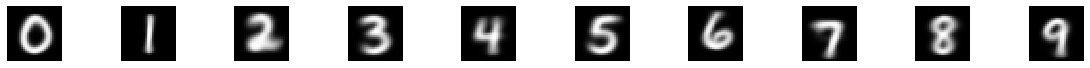

In [0]:
# Visualization
import matplotlib.pyplot as plt

digit_size = 28
z_sample = torch.randn(1, 2) # random 
plt.figure(figsize=(20, 1))

for i in range(10):
    c = torch.zeros((1, 10))
    c[0][i] = 1
    
    cvae.eval()
    with torch.no_grad():
        z_sample = z_sample.to(device)
        c = c.to(device)
        img = cvae.decoder(z_sample, c)
        # reshape (if needed)
        img = img.detach().cpu().view(28, 28).numpy()

    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(img, cmap='Greys_r',)
plt.show()


# UMAP
These links help you to understand how UMAP works.

[Scanpy anndata](https://anndata.readthedocs.io/en/stable/)

[Scanpy umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html)

[Example](https://icb-scanpy-tutorials.readthedocs-hosted.com/en/latest/visualizing-marker-genes.html)

In [0]:
# Create latent space and labels for UMAP
cvae.eval()
latent = None
labels = None
with torch.no_grad():
    for data, cond in test_loader:
      if data.size() == torch.Size([128, 1, 28, 28]):
        data = data.view(128, 28*28)
        data = data.to(device)
        
        if labels is None:
            labels = cond
        else:
            labels = torch.cat((labels, cond), 0)
            
        cond = one_hott(cond) # create one-hot condition
        cond = cond.to(device)

        # recon_batch, mu, log_var = cvae(data, cond)
        # batch_latent = cvae.sampling(mu, log_var)
      
        batch_latent = cvae.encoder(data,cond)

        if latent is None:
            latent = batch_latent[0]
        else:
            latent = torch.cat((latent, batch_latent[0]), 0)
labels = labels.detach().numpy()
latent = latent.cpu().detach().numpy()


In [0]:
!pip install scanpy

     |████████████████████████████████| 6.5MB 4.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 92kB 13.1MB/s 
     |████████████████████████████████| 3.7MB 70.7MB/s 
     |████████████████████████████████| 13.0MB 18.3MB/s 
  Using cached https://files.pythonhosted.org/packages/1d/70/97966deebaeeda0b81d3cd63ba9f8ec929b838871ed17476de9d8159db3e/setuptools_scm-3.3.3-py2.py3-none-any.whl
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 20.2MB 109kB/s 
  Created wheel for scanpy: filename=scanpy-1.4.5-cp36-none-any.whl size=264431 sha256=d79f9b5a5bd37c222ed3a4d702bc555b38651abba84b9ae9f767af6d9f1c3d2b
  Stored in directory: /root/.cache/pip/wheels/30/4e/27/5681d399489fed5e4d777bb8027afea4c0a4aeb7e89e789150
Successfully built scanpy
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.

In [0]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent, obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)
print('KL Coefficient:1, Reconstruction Coefficient:1')

In [0]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent, obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)
print('KL Coefficient:0.07, Reconstruction Coefficient:1')

In [0]:
# UMAP
import scanpy as sc

labels = labels.astype(str)
latent_anndata = sc.AnnData(X=latent, obs={"Numbers": labels})
sc.pp.neighbors(latent_anndata)
sc.tl.umap(latent_anndata)

# Visualization
sc.pl.umap(latent_anndata, color=["Numbers"],
           frameon=False,
           legend_loc=False,
           show=True)
print('KL Coefficient:1, Reconstruction Coefficient:0.07')